# Práctica 2: Redes Neuronales
## Antonio Gálvez, Pablo Millán y José Antonio Laserna

## Funciones auxiliares

In [2]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

def evaluate_neural_network(model, train_loader, test_loader, criteria_function, optimizer, epochs, plot_accuracy=False, seed=1):
    # Establecer semilla para reproducibilidad
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print("Device:", device)

    accuracy_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criteria_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Evaluación tras cada época
        model.eval()
        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(preds.cpu().numpy())

        correctos = sum(p == t for p, t in zip(predicted_labels, true_labels))
        total = len(true_labels)
        accuracy = 100 * correctos / total
        accuracy_history.append(accuracy)

        print(f"Epoch {epoch+1} - Loss: {running_loss:.4f} - Accuracy: {accuracy:.2f}%")

    if plot_accuracy:
        plt.plot(range(1, epochs + 1), accuracy_history, marker='o')
        plt.title('Evolución de la Precisión por Época')
        plt.xlabel('Época')
        plt.ylabel('Precisión (%)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return true_labels, predicted_labels, accuracy_history

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names=None, title='Matriz de Confusión'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()

## Carga de datos y librerías

In [4]:
# import os
# from google.colab import drive

# drive.mount('/content/drive')

# ruta_x20 = '/content/drive/My Drive/SIGE-P2/data x20'

# # Para comprobar que la ruta funciona correctamente
# print(os.listdir(ruta_x20))

In [5]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import random
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import random_split, Subset
from torch.utils.data import DataLoader

from collections import Counter
from torchvision.datasets import ImageFolder
import optuna

C:\Users\anton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Garantizar reproducibilidad
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1)

## Particionamiento

In [7]:
#ruta_imagenes_x20 = '/content/drive/My Drive/SIGE-P2/data x20'
ruta_imagenes_x20 = 'archivos/data x20'

# Transformaciones necesarias (hay que convertir las imágenes a tensores)
transformaciones = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Dataset con transformaciones
dataset = datasets.ImageFolder(root=ruta_imagenes_x20, transform=transformaciones)

# Agrupamos en lotes de 20 imágenes para el entrenamiento, mezclándolas.
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Verificar
images, labels = next(iter(dataloader))
print(f"Forma del lote: {images.shape}")
print(f"Clases (primer lote): {labels}")

Forma del lote: torch.Size([32, 3, 224, 224])
Clases (primer lote): tensor([ 0, 10, 18, 16, 13, 10, 16, 19,  1, 14, 12, 15, 12, 19, 17,  9,  2,  2,
        10,  6,  7, 18,  7,  4,  0,  1, 17,  3,  0, 10,  3, 18])


Tras aplicar las transformaciones anteriores, hemos dividido el dataset en lotes de 32 imágenes, que se enviarán a la vez al entrenamiento con el fin de acelerarlo y permitir la paralelización.

Los lotes resultantes son de 32 imágenes con 3 canales (RGB) con un tamaño de 224x224 píxeles.

A continuación, vamos a dividir el dataset en conjuntos de entrenamiento y validación para comenzar con el entrenamiento del modelo.

In [8]:
# Selección de las primeras 20 clases (etiquetas 0 a 19)
indices_filtrados = [i for i, (_, label) in enumerate(dataset) if label < 20]
dataset_20_clases = Subset(dataset, indices_filtrados)

# División en entrenamiento y validación
tam_total = len(dataset_20_clases)
tam_train = int(0.8 * tam_total)
tam_val = tam_total - tam_train

generator = torch.Generator().manual_seed(42)  # semilla para reproducibilidad
dataset_train, dataset_val = random_split(dataset_20_clases, [tam_train, tam_val], generator=generator)

# DataLoaders
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32)


Mostramos algunas imágenes de train para comprobar que se han cargado correctamente

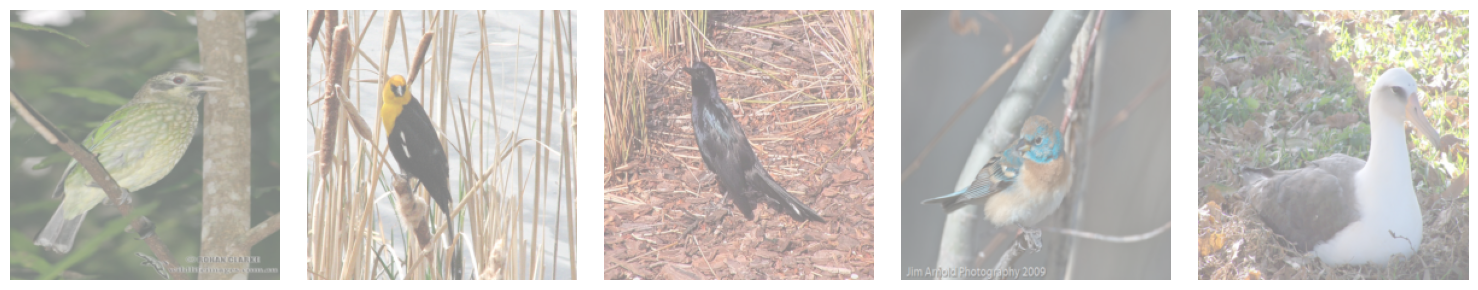

In [9]:
# Obtener el primer batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostrar las primeras 5 imágenes
plt.figure(figsize=(15, 3))
for i in range(5):
    img = images[i]        # tensor con shape (C, H, W)
    img = img / 2 + 0.5     # desnormalizar (si usaste mean=0.5, std=0.5)
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))  # convertir a (H, W, C)

    plt.subplot(1, 5, i+1)
    plt.imshow(npimg)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Análisis exploratorio

Primeramente, vamos a comprobar como está distribuida la cantidad de imágenes por clase, leyendo el fichero `image_class_labels.txt`, que contiene la clase asociada a cada imagen. Esto nos permite analizar el balance de clases para considerar el uso de balanceo de carga.

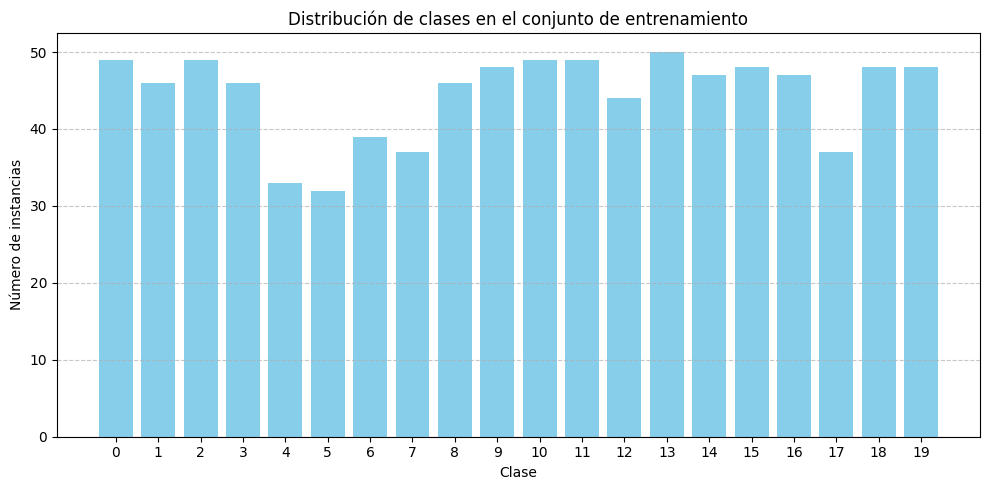

In [10]:
# Contar cuántas instancias hay de cada clase
conteo_clases = Counter()

for _, labels in train_loader:
    for label in labels:
        conteo_clases[int(label)] += 1

# Ordenar por clase
clases = sorted(conteo_clases.keys())
frecuencias = [conteo_clases[c] for c in clases]

# Graficar
plt.figure(figsize=(10, 5))
plt.bar(clases, frecuencias, color='skyblue')
plt.xlabel('Clase')
plt.ylabel('Número de instancias')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.xticks(clases)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Como se puede observar, algunas clases tienen claramente menos representación que otras, aunque la mayoría ronda entre 40 y 50 instancias. Se aplicarán medidas de balanceo de clases para paliar los posibles sesgos que esto pueda provocar al modelo.

## Modelo propio

### Evaluación inicial

Partimos de una topología base del usuario [omaratef3221](https://github.com/omaratef3221/pytorch_tutorials). Esta red fue usada para un problema de clasificación de imágenes de distintas especies de animales, y se logró obtener una precisión de más del 95%. Es por las similitudes con el problema de clasificación de aves que se decidió tomar esta topología como base para el problema. Se adaptó la última capa a las 20 capas del problema.

Se cuenta con las siguientes capas:

Capas convolucionales (Conv1, Conv2, Conv3): Se encargan de extraer características de la imagen base
Pooling: Se encarga de reducir el tamaño de las muestras obtenidas en las capas convolucionales. Se ejecuta entre cada una de estas. En este caso reduce su tamaño a la mitad.
Relu: es una activación que hace que las salidas negativas se vuelvan cero y deja pasar las positivas, lo que permite a la red aprender relaciones no lineales de forma eficiente.
Flatten y Linear: Se encargan de
Output: Capa de salida para las 20 clases del problema.

In [11]:
data_pairs = []

class MiCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 28 * 28, 128)  # Ajustado a entrada 224x224
        self.output = nn.Linear(128, 20)  # 20 clases

    def forward(self, x):
        x = self.pooling(self.relu(self.conv1(x)))  # (32, 112, 112)
        x = self.pooling(self.relu(self.conv2(x)))  # (64, 56, 56)
        x = self.pooling(self.relu(self.conv3(x)))  # (128, 28, 28)
        x = self.flatten(x)
        x = self.relu(self.linear(x))
        x = self.output(x)
        return x

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MiCNN().to(device)

print(next(model.parameters()).device) # si está en cuda:0 está en la gráfica


criterio = nn.CrossEntropyLoss()
optimizador = torch.optim.Adam(model.parameters(), lr=0.001)

cuda:0


In [13]:
true_labels, predicted_labels, acc = evaluate_neural_network(
    model,
    train_loader,
    val_loader,
    criteria_function=criterio,
    optimizer=optimizador,
    epochs=10
)

data_pairs.append([true_labels, predicted_labels])

#plot_confusion_matrix(true_labels, predicted_labels, class_names=[str(i) for i in range(20)])

Device: cuda
Epoch 1 - Loss: 84.5542 - Accuracy: 6.73%
Epoch 2 - Loss: 79.0849 - Accuracy: 16.59%
Epoch 3 - Loss: 69.1955 - Accuracy: 19.28%
Epoch 4 - Loss: 56.1580 - Accuracy: 26.01%
Epoch 5 - Loss: 46.1205 - Accuracy: 33.63%
Epoch 6 - Loss: 34.4612 - Accuracy: 27.35%
Epoch 7 - Loss: 26.1992 - Accuracy: 27.35%
Epoch 8 - Loss: 18.8585 - Accuracy: 27.80%
Epoch 9 - Loss: 14.6749 - Accuracy: 34.08%
Epoch 10 - Loss: 10.3361 - Accuracy: 27.80%


En una primera ejecución, obtenemos un accuracy en test de más del 31.39% con un entrenamiento de 30 épocas (REVISAR DATO).

### Ajuste de topología

#### Añadir capa convolucional

cuda:0
Device: cuda
Epoch 1 - Loss: 84.1398 - Accuracy: 6.28%
Epoch 2 - Loss: 81.8868 - Accuracy: 8.07%
Epoch 3 - Loss: 76.0828 - Accuracy: 17.04%
Epoch 4 - Loss: 64.8126 - Accuracy: 19.73%
Epoch 5 - Loss: 54.3703 - Accuracy: 25.11%
Epoch 6 - Loss: 46.3425 - Accuracy: 21.52%
Epoch 7 - Loss: 41.8123 - Accuracy: 27.80%
Epoch 8 - Loss: 34.6119 - Accuracy: 31.39%
Epoch 9 - Loss: 27.4473 - Accuracy: 31.39%
Epoch 10 - Loss: 19.7317 - Accuracy: 34.08%
Epoch 11 - Loss: 14.9544 - Accuracy: 32.74%
Epoch 12 - Loss: 11.0777 - Accuracy: 29.15%
Epoch 13 - Loss: 6.3826 - Accuracy: 32.74%
Epoch 14 - Loss: 4.4773 - Accuracy: 28.25%
Epoch 15 - Loss: 6.0512 - Accuracy: 30.94%


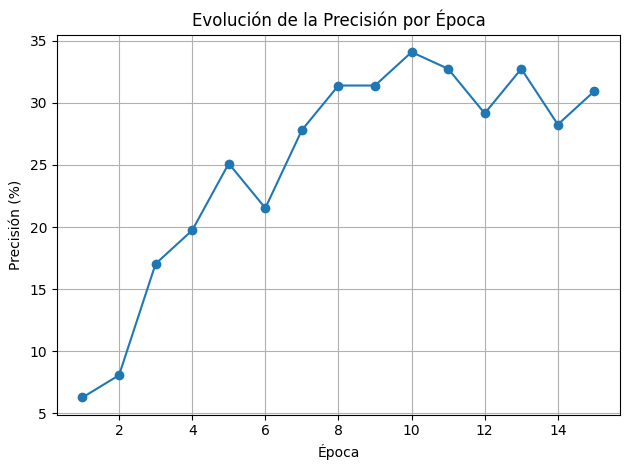

In [14]:
class MiCNN_2(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(256 * 14 * 14, 128)
        self.output = nn.Linear(128, 20)  # 20 clases

    def forward(self, x):
        x = self.pooling(self.relu(self.conv1(x)))  # (32, 112, 112)
        x = self.pooling(self.relu(self.conv2(x)))  # (64, 56, 56)
        x = self.pooling(self.relu(self.conv3(x)))  # (128, 28, 28)
        x = self.pooling(self.relu(self.conv4(x)))  # (256, 14, 14)
        x = self.flatten(x)
        x = self.relu(self.linear(x))
        x = self.output(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MiCNN_2().to(device)

print(next(model.parameters()).device) # si está en cuda:0 está en la gráfica


criterio = nn.CrossEntropyLoss()
optimizador = torch.optim.Adam(model.parameters(), lr=0.001)

true_labels, predicted_labels, acc = evaluate_neural_network(
    model,
    train_loader,
    val_loader,
    criteria_function=criterio,
    optimizer=optimizador,
    epochs=15,
    plot_accuracy=True
)

#data_pairs.append([true_labels, predicted_labels])
#plot_confusion_matrix(true_labels, predicted_labels, class_names=[str(i) for i in range(20)])

#### Añadir BatchNorm

Ayuda a estabilizar el entrenamiento (desarrollar)

cuda:0
Device: cuda
Epoch 1 - Loss: 366.1373 - Accuracy: 8.07%
Epoch 2 - Loss: 84.6797 - Accuracy: 12.56%
Epoch 3 - Loss: 77.5889 - Accuracy: 15.70%
Epoch 4 - Loss: 73.7135 - Accuracy: 16.59%
Epoch 5 - Loss: 71.3154 - Accuracy: 17.04%
Epoch 6 - Loss: 70.4631 - Accuracy: 13.90%
Epoch 7 - Loss: 65.3399 - Accuracy: 17.04%
Epoch 8 - Loss: 62.7639 - Accuracy: 17.49%
Epoch 9 - Loss: 58.2533 - Accuracy: 20.63%
Epoch 10 - Loss: 56.4314 - Accuracy: 20.63%
Epoch 11 - Loss: 50.4895 - Accuracy: 22.42%
Epoch 12 - Loss: 45.0718 - Accuracy: 25.56%
Epoch 13 - Loss: 43.8087 - Accuracy: 22.87%
Epoch 14 - Loss: 38.8474 - Accuracy: 22.87%
Epoch 15 - Loss: 35.6272 - Accuracy: 24.22%


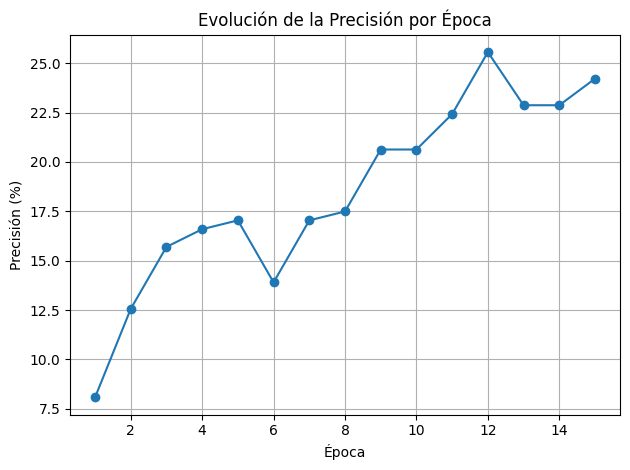

In [15]:
class MiCNN_BatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 28 * 28, 128)
        self.output = nn.Linear(128, 20)

    def forward(self, x):
        x = self.pooling(self.relu(self.bn1(self.conv1(x))))
        x = self.pooling(self.relu(self.bn2(self.conv2(x))))
        x = self.pooling(self.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.relu(self.linear(x))
        x = self.output(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MiCNN_BatchNorm().to(device)

print(next(model.parameters()).device) # si está en cuda:0 está en la gráfica


criterio = nn.CrossEntropyLoss()
optimizador = torch.optim.Adam(model.parameters(), lr=0.001)

true_labels, predicted_labels, acc = evaluate_neural_network(
    model,
    train_loader,
    val_loader,
    criteria_function=criterio,
    optimizer=optimizador,
    epochs=15,
    plot_accuracy=True
)

#data_pairs.append([true_labels, predicted_labels])
#plot_confusion_matrix(true_labels, predicted_labels, class_names=[str(i) for i in range(20)])

#### Agregar dropout

cuda:0
Device: cuda
Epoch 1 - Loss: 86.2182 - Accuracy: 6.28%
Epoch 2 - Loss: 82.5470 - Accuracy: 8.97%
Epoch 3 - Loss: 80.2892 - Accuracy: 12.11%
Epoch 4 - Loss: 76.0309 - Accuracy: 13.00%
Epoch 5 - Loss: 73.8634 - Accuracy: 13.90%
Epoch 6 - Loss: 68.7077 - Accuracy: 17.04%
Epoch 7 - Loss: 63.5739 - Accuracy: 21.97%
Epoch 8 - Loss: 59.3707 - Accuracy: 26.01%
Epoch 9 - Loss: 55.5403 - Accuracy: 24.66%
Epoch 10 - Loss: 50.2832 - Accuracy: 28.25%
Epoch 11 - Loss: 46.7613 - Accuracy: 27.80%
Epoch 12 - Loss: 41.6796 - Accuracy: 31.39%
Epoch 13 - Loss: 37.1759 - Accuracy: 31.84%
Epoch 14 - Loss: 34.1391 - Accuracy: 31.39%
Epoch 15 - Loss: 33.8285 - Accuracy: 30.94%


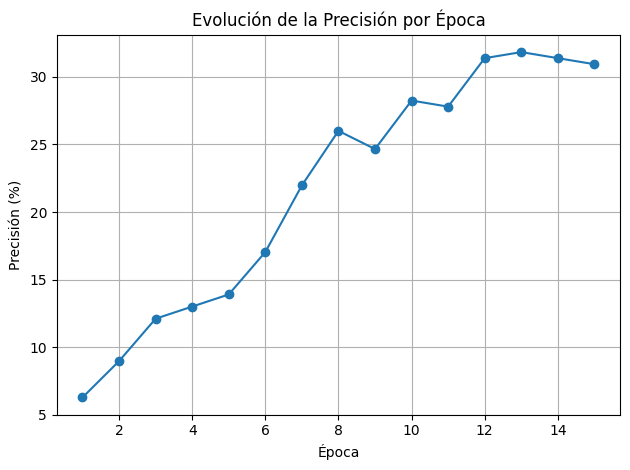

In [16]:
class MiCNN_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 28 * 28, 128)
        self.output = nn.Linear(128, 20)

    def forward(self, x):
        x = self.pooling(self.relu(self.conv1(x)))
        x = self.pooling(self.relu(self.conv2(x)))
        x = self.pooling(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.linear(x)))
        x = self.output(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MiCNN_Dropout().to(device)

print(next(model.parameters()).device) # si está en cuda:0 está en la gráfica


criterio = nn.CrossEntropyLoss()
optimizador = torch.optim.Adam(model.parameters(), lr=0.001)

true_labels, predicted_labels, acc = evaluate_neural_network(
    model,
    train_loader,
    val_loader,
    criteria_function=criterio,
    optimizer=optimizador,
    epochs=15,
    plot_accuracy=True
)

#data_pairs.append([true_labels, predicted_labels])

#### Usar LeakyReLu para la capa ReLu

cuda:0
Device: cuda
Epoch 1 - Loss: 89.1544 - Accuracy: 9.87%
Epoch 2 - Loss: 76.3440 - Accuracy: 14.80%
Epoch 3 - Loss: 58.8636 - Accuracy: 23.77%
Epoch 4 - Loss: 44.5206 - Accuracy: 24.22%
Epoch 5 - Loss: 32.2633 - Accuracy: 27.80%
Epoch 6 - Loss: 21.3712 - Accuracy: 26.46%
Epoch 7 - Loss: 16.2199 - Accuracy: 25.56%
Epoch 8 - Loss: 13.8116 - Accuracy: 28.70%
Epoch 9 - Loss: 9.2166 - Accuracy: 29.60%
Epoch 10 - Loss: 4.8574 - Accuracy: 30.49%
Epoch 11 - Loss: 2.7702 - Accuracy: 29.15%
Epoch 12 - Loss: 2.4796 - Accuracy: 29.15%
Epoch 13 - Loss: 1.4661 - Accuracy: 30.04%
Epoch 14 - Loss: 0.4642 - Accuracy: 32.74%
Epoch 15 - Loss: 0.1222 - Accuracy: 32.29%


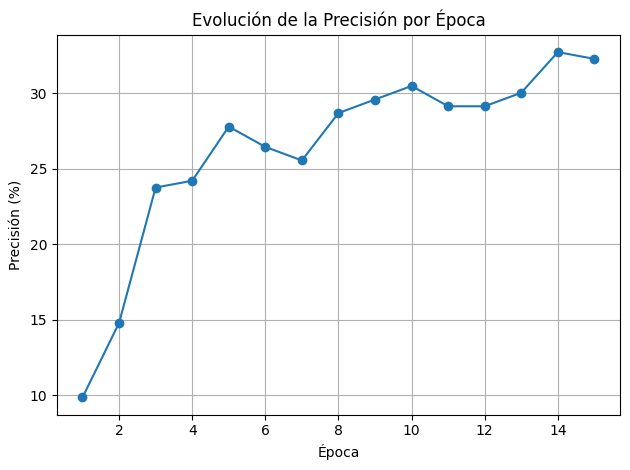

In [17]:
class MiCNN_LeakyReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.LeakyReLU(0.1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 28 * 28, 128)
        self.output = nn.Linear(128, 20)

    def forward(self, x):
        x = self.pooling(self.relu(self.conv1(x)))
        x = self.pooling(self.relu(self.conv2(x)))
        x = self.pooling(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.linear(x))
        x = self.output(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MiCNN_LeakyReLU().to(device)

print(next(model.parameters()).device) # si está en cuda:0 está en la gráfica


criterio = nn.CrossEntropyLoss()
optimizador = torch.optim.Adam(model.parameters(), lr=0.001)

true_labels, predicted_labels, acc = evaluate_neural_network(
    model,
    train_loader,
    val_loader,
    criteria_function=criterio,
    optimizer=optimizador,
    epochs=15,
    plot_accuracy=True
)

#data_pairs.append([true_labels, predicted_labels])
#plot_confusion_matrix(true_labels, predicted_labels, class_names=[str(i) for i in range(20)])

#### Usar Adaptative AvgPool2D

cuda:0
Device: cuda
Epoch 1 - Loss: 83.9717 - Accuracy: 6.73%
Epoch 2 - Loss: 82.9584 - Accuracy: 8.52%
Epoch 3 - Loss: 80.3444 - Accuracy: 7.17%
Epoch 4 - Loss: 78.6559 - Accuracy: 6.73%
Epoch 5 - Loss: 78.4755 - Accuracy: 10.76%
Epoch 6 - Loss: 76.5999 - Accuracy: 13.00%
Epoch 7 - Loss: 75.9923 - Accuracy: 11.21%
Epoch 8 - Loss: 75.4588 - Accuracy: 14.35%
Epoch 9 - Loss: 74.3278 - Accuracy: 12.56%
Epoch 10 - Loss: 73.8156 - Accuracy: 13.45%
Epoch 11 - Loss: 72.3519 - Accuracy: 14.35%
Epoch 12 - Loss: 71.3965 - Accuracy: 16.14%
Epoch 13 - Loss: 70.1469 - Accuracy: 15.70%
Epoch 14 - Loss: 69.0769 - Accuracy: 12.56%
Epoch 15 - Loss: 69.1996 - Accuracy: 14.35%


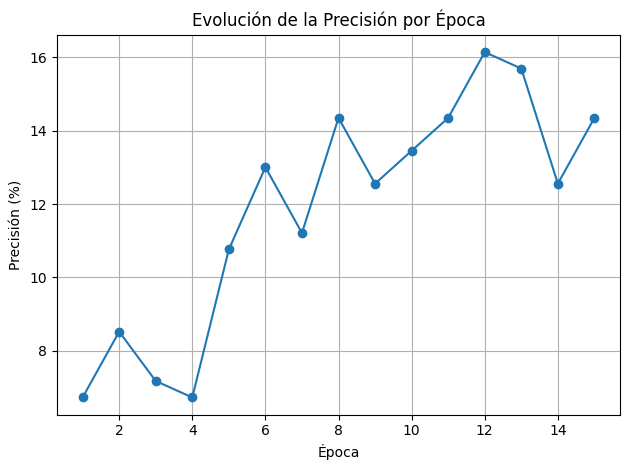

In [18]:
class MiCNN_AdaptivePool(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(128, 128)
        self.output = nn.Linear(128, 20)

    def forward(self, x):
        x = self.pooling(self.relu(self.conv1(x)))
        x = self.pooling(self.relu(self.conv2(x)))
        x = self.pooling(self.relu(self.conv3(x)))
        x = self.avgpool(x)           # (batch, 128, 1, 1)
        x = x.view(x.size(0), -1)     # (batch, 128)
        x = self.relu(self.linear(x))
        x = self.output(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MiCNN_AdaptivePool().to(device)

print(next(model.parameters()).device) # si está en cuda:0 está en la gráfica


criterio = nn.CrossEntropyLoss()
optimizador = torch.optim.Adam(model.parameters(), lr=0.001)

true_labels, predicted_labels, acc = evaluate_neural_network(
    model,
    train_loader,
    val_loader,
    criteria_function=criterio,
    optimizer=optimizador,
    epochs=15,
    plot_accuracy=True
)

### Ajuste de la función de coste

Para un sistema de clasificación multiclase como este, donde una imagen pertenece a una sola clase, las funciones de coste adecuadas para probar son:
- Entropía cruzada (CrossEntropyLoss)
- Función de pérdida de verosimilitud negativa (NLLLoss)
- Función de pérdida de márgen múltiple (MultiMarginLoss)

Para NLLLoss, necesitamos aplicar una capa log_softmax a la red. Teniendo eso en cuenta, vamos a ejecutar a 20 épocas con las tres, y verificar cual obtiene mejores resultados.


Evaluando con función de coste: CrossEntropyLoss
Época 1/20 - Precisión: 5.38%
Época 2/20 - Precisión: 8.07%
Época 3/20 - Precisión: 15.70%
Época 4/20 - Precisión: 21.97%
Época 5/20 - Precisión: 27.35%
Época 6/20 - Precisión: 24.66%
Época 7/20 - Precisión: 22.87%
Época 8/20 - Precisión: 27.80%
Época 9/20 - Precisión: 25.56%
Época 10/20 - Precisión: 25.11%
Época 11/20 - Precisión: 25.11%
Época 12/20 - Precisión: 27.35%
Época 13/20 - Precisión: 30.04%
Época 14/20 - Precisión: 30.04%
Época 15/20 - Precisión: 31.39%
Época 16/20 - Precisión: 26.01%
Época 17/20 - Precisión: 24.22%
Época 18/20 - Precisión: 23.77%
Época 19/20 - Precisión: 26.01%
Época 20/20 - Precisión: 27.35%

Evaluando con función de coste: NLLLoss
Época 1/20 - Precisión: 11.21%
Época 2/20 - Precisión: 18.39%
Época 3/20 - Precisión: 20.63%
Época 4/20 - Precisión: 23.32%
Época 5/20 - Precisión: 25.56%
Época 6/20 - Precisión: 27.35%
Época 7/20 - Precisión: 27.35%
Época 8/20 - Precisión: 22.42%
Época 9/20 - Precisión: 29.15%
É

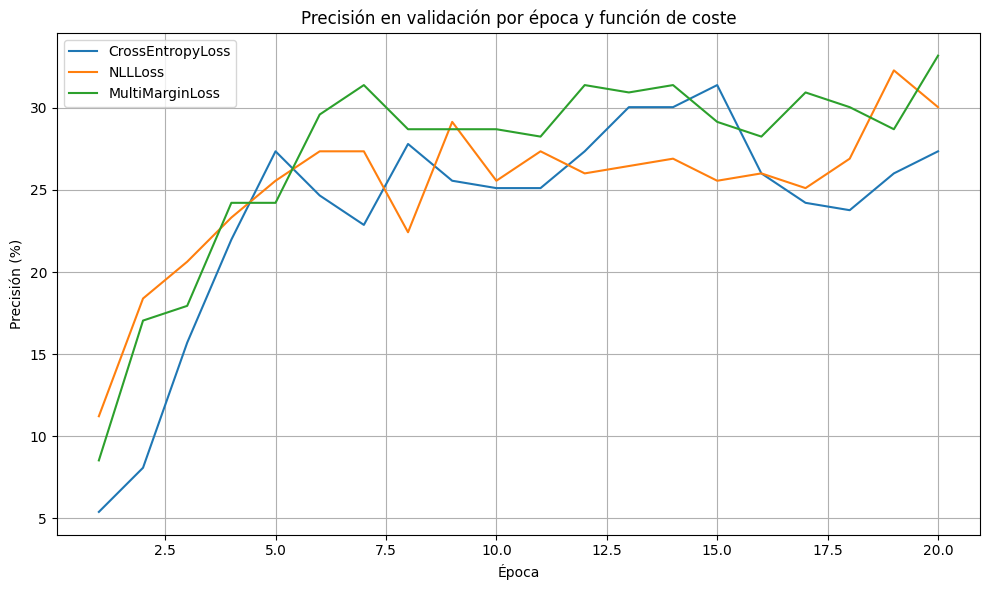

In [19]:
# Lista de funciones de coste a comparar
criterios = {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
    'NLLLoss': nn.NLLLoss(),
    'MultiMarginLoss': nn.MultiMarginLoss()
}

EPOCHS = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Registraremos las precisiones en cada época para graficarlas
historico_precisiones = {nombre: [] for nombre in criterios.keys()}

for nombre_criterio, criterio in criterios.items():
    print(f"\nEvaluando con función de coste: {nombre_criterio}")

    # Crear modelo nuevo, y en el caso de NLLLoss, añadir la capa softmax de salida.
    model = MiCNN()
    if nombre_criterio == 'NLLLoss':
        class ModeloConLogSoftmax(MiCNN):
            def forward(self, x):
                x = super().forward(x)
                return torch.nn.functional.log_softmax(x, dim=1)
        model = ModeloConLogSoftmax()

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

    for epoch in range(EPOCHS):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterio(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluar precisión tras cada época para comparar
        model.eval()
        true_labels = []
        predicted_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(preds.cpu().numpy())

        correctos = sum(p == t for p, t in zip(predicted_labels, true_labels))
        total = len(true_labels)
        acc = 100 * correctos / total if total > 0 else 0
        historico_precisiones[nombre_criterio].append(acc)
        print(f"Época {epoch+1}/{EPOCHS} - Precisión: {acc:.2f}%")

# Graficar las curvas de precisión
plt.figure(figsize=(10, 6))
for nombre, lista_acc in historico_precisiones.items():
    plt.plot(range(1, EPOCHS+1), lista_acc, label=nombre)

plt.title('Precisión en validación por época y función de coste')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Como podemos comprobar, CrossEntropyLoss y NLLLoss siguen tendencias muy parecidas de precisión. Esto se debe a que, matemáticamente, son algoritmos equivalentes, ya que CrossEntropyLoss hace las mismas operaciones que NLLLoss pero aplicando una capa Log_Softmax en la salida, cosa que, para usar NLLLoss, tenemos que modificar manualmente en la topología. 

Por otra parte, MultiMarginLoss parece funcionar mejor en este problema, manteniéndose por encima de las otras dos funciones de coste en casi todas las épocas. Podemos afirmar, al menos con los parámetros actuales, que <b>MultiMarginLoss es la mejor función de coste</b> para este problema de clasificación.


### Ajuste del optimizador

El optimizador en la red neuronal es el algoritmo que ajusta los pesos del modelo tras la clasificación de cada lote (batch), de forma que en función del error de la predicción:
- Se calcula el gradiente (en qué medida debe cambiar cada peso).
- Actualiza los pesos para reducir el error en las siguientes predicciones.

Los optimizadores que hemos considerado para la comparación son los siguientes:

- <b>SGD</b> (Stochastic Gradient Descent)

- <b>Adam</b> (Adaptive Moment Estimation)

- <b>AdamW</b> (Adam con Weight Decay)

- <b>RMSprop</b> (Root Mean Square Propagation)

Para hacer comparaciones, vamos a probar a aplicar cada uno de esos optimizadores con 10, 15 y 20 épocas, el código a continuación hace todas las ejecuciones y muestra una tabla con la comparativa, además de mostrar la mejor combinación de épocas - optimizador.

In [20]:
# Lista de optimizadores y épocas a comparar
optimizadores = ['SGD', 'Adam', 'AdamW', 'RMSprop']
epocas_lista = [10, 15, 20]
resultados = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

for epocas in epocas_lista:
    for opt_name in optimizadores:
        print(f"\nEntrenando con optimizador {opt_name} durante {epocas} épocas")
        
        model = MiCNN()
        if opt_name == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        elif opt_name == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        elif opt_name == 'AdamW':
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
        elif opt_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
        else:
            raise ValueError("Optimizador no soportado")

        true_labels, predicted_labels, acc = evaluate_neural_network(model, train_loader, val_loader, criterion, optimizer, epocas)

        correctos = sum([p == t for p, t in zip(predicted_labels, true_labels)])
        total = len(true_labels)
        acc = 100 * correctos / total if total > 0 else 0

        resultados.append({'Optimizador': opt_name, 'Épocas': epocas, 'Precisión': acc})

# Mostrar tabla de resultados
import pandas as pd
df_resultados = pd.DataFrame(resultados)
print("\nTabla de resultados:")
print(df_resultados)

# Mejor combinación
mejor = df_resultados.loc[df_resultados['Precisión'].idxmax()]
print(f"\nMejor combinación: {mejor['Optimizador']} con {mejor['Épocas']} épocas → {mejor['Precisión']:.2f}% precisión")


Entrenando con optimizador SGD durante 10 épocas
Device: cuda
Epoch 1 - Loss: 84.0499 - Accuracy: 6.28%
Epoch 2 - Loss: 83.6609 - Accuracy: 7.62%
Epoch 3 - Loss: 83.3302 - Accuracy: 4.93%
Epoch 4 - Loss: 81.6063 - Accuracy: 8.07%
Epoch 5 - Loss: 79.6620 - Accuracy: 7.17%
Epoch 6 - Loss: 77.1079 - Accuracy: 12.56%
Epoch 7 - Loss: 72.0154 - Accuracy: 13.90%
Epoch 8 - Loss: 69.2387 - Accuracy: 19.73%
Epoch 9 - Loss: 64.7193 - Accuracy: 19.73%
Epoch 10 - Loss: 58.5115 - Accuracy: 25.56%

Entrenando con optimizador Adam durante 10 épocas
Device: cuda
Epoch 1 - Loss: 85.5715 - Accuracy: 7.17%
Epoch 2 - Loss: 81.2750 - Accuracy: 9.87%
Epoch 3 - Loss: 72.9692 - Accuracy: 17.49%
Epoch 4 - Loss: 59.7600 - Accuracy: 21.97%
Epoch 5 - Loss: 47.1647 - Accuracy: 23.32%
Epoch 6 - Loss: 35.8315 - Accuracy: 27.80%
Epoch 7 - Loss: 28.8840 - Accuracy: 28.70%
Epoch 8 - Loss: 22.0959 - Accuracy: 26.01%
Epoch 9 - Loss: 17.0431 - Accuracy: 28.25%
Epoch 10 - Loss: 11.3614 - Accuracy: 27.35%

Entrenando con op

Aunque hay un factor azar, la mayor precisión la hemos obtenido del optimizador AdamW con 20 épocas. Sin embargo, podría haber una mejora de la precisión con un número de épocas con el que no hemos probado. Vamos a probar el modelo entrenado con AdamW en el conjunto de validación en un rango de 5 a 30 épocas, y así estimar cual es el número óptimo de épocas para el entrenamiento.


Época 1/30
🔹 Loss: 83.3013
Precisión en validación: 9.42%

Época 2/30
🔹 Loss: 71.4059
Precisión en validación: 21.08%

Época 3/30
🔹 Loss: 55.9458
Precisión en validación: 25.56%

Época 4/30
🔹 Loss: 46.0836
Precisión en validación: 31.39%

Época 5/30
🔹 Loss: 35.9992
Precisión en validación: 30.04%

Época 6/30
🔹 Loss: 26.7370
Precisión en validación: 24.66%

Época 7/30
🔹 Loss: 19.8783
Precisión en validación: 26.91%

Época 8/30
🔹 Loss: 12.8403
Precisión en validación: 30.49%

Época 9/30
🔹 Loss: 10.8475
Precisión en validación: 26.91%

Época 10/30
🔹 Loss: 8.6347
Precisión en validación: 25.56%

Época 11/30
🔹 Loss: 6.5434
Precisión en validación: 29.15%

Época 12/30
🔹 Loss: 2.2134
Precisión en validación: 29.60%

Época 13/30
🔹 Loss: 5.6490
Precisión en validación: 26.46%

Época 14/30
🔹 Loss: 9.4751
Precisión en validación: 31.84%

Época 15/30
🔹 Loss: 2.5207
Precisión en validación: 30.49%

Época 16/30
🔹 Loss: 0.8152
Precisión en validación: 31.39%

Época 17/30
🔹 Loss: 0.3460
Precisión en 

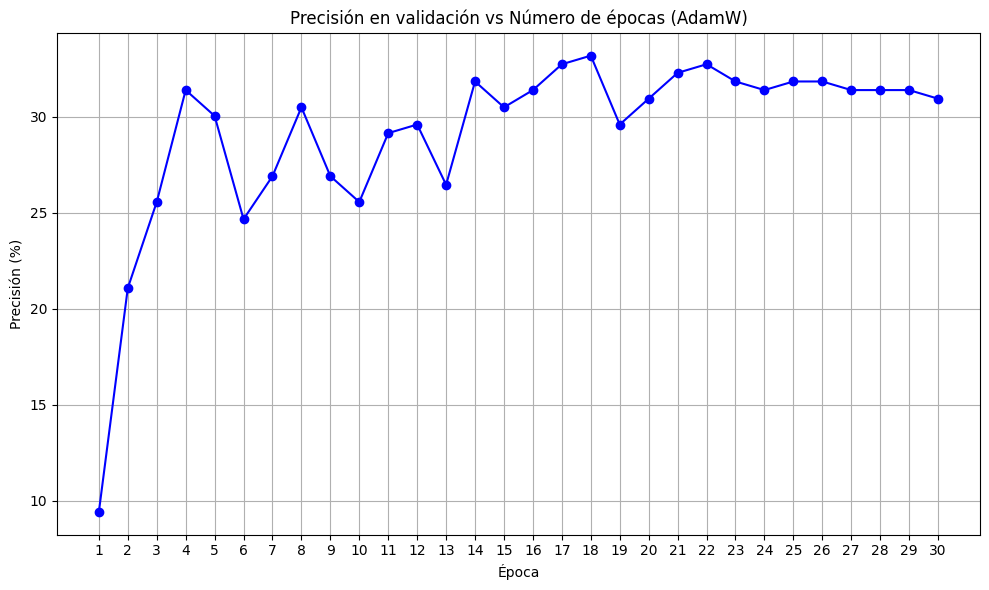

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = MiCNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

resultados = []
EPOCHS = 30  # Entrenamos hasta la época 30

for epoch in range(1, EPOCHS + 1):
    print(f"\nÉpoca {epoch}/{EPOCHS}")
    
    # Entrenamiento
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"🔹 Loss: {running_loss:.4f}")

    # Evaluación en validación tras esta época
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    correctos = sum(p == t for p, t in zip(predicted_labels, true_labels))
    total = len(true_labels)
    acc = 100 * correctos / total if total > 0 else 0
    resultados.append({'Época': epoch, 'Precisión': acc})
    print(f"Precisión en validación: {acc:.2f}%")

# Convertir resultados a DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostrar tabla
print("\nResultados por época:")
print(df_resultados)

# Mostrar gráfico
plt.figure(figsize=(10, 6))
plt.plot(df_resultados['Época'], df_resultados['Precisión'], marker='o', linestyle='-', color='blue')
plt.title("Precisión en validación vs Número de épocas (AdamW)")
plt.xlabel("Época")
plt.ylabel("Precisión (%)")
plt.grid(True)
plt.xticks(range(1, EPOCHS + 1))
plt.tight_layout()
plt.show()

### Modelo mejorado actual

A continuación construimos un modelo de red neuronal basado en los cambios positivos y mejores resultados que hemos obtenido en las experimentaciones anteriores.

In [22]:
class MiCNN_definitivo_v3(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 320, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(320)

        self.conv5 = nn.Conv2d(320, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        self.conv6 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.33955714678659366)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 3 * 3, 128)
        self.output = nn.Linear(128, 20)  # 20 clases

    def forward(self, x):
        x = self.pooling(self.relu(self.bn1(self.conv1(x))))
        x = self.pooling(self.relu(self.bn2(self.conv2(x))))
        x = self.pooling(self.relu(self.bn3(self.conv3(x))))
        x = self.pooling(self.relu(self.bn4(self.conv4(x))))
        x = self.pooling(self.relu(self.bn5(self.conv5(x))))
        x = self.pooling(self.relu(self.bn6(self.conv6(x))))

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.linear(x))
        x = self.output(x)
        return x

cuda:0
Device: cuda
Epoch 1 - Loss: 81.1957 - Accuracy: 12.11%
Epoch 2 - Loss: 66.0635 - Accuracy: 17.94%
Epoch 3 - Loss: 55.5717 - Accuracy: 27.80%
Epoch 4 - Loss: 46.0869 - Accuracy: 34.98%
Epoch 5 - Loss: 39.0154 - Accuracy: 42.15%
Epoch 6 - Loss: 35.5701 - Accuracy: 45.29%
Epoch 7 - Loss: 29.9323 - Accuracy: 47.09%
Epoch 8 - Loss: 26.5808 - Accuracy: 45.29%
Epoch 9 - Loss: 24.1469 - Accuracy: 41.26%
Epoch 10 - Loss: 20.7189 - Accuracy: 50.22%
Epoch 11 - Loss: 16.9911 - Accuracy: 50.22%
Epoch 12 - Loss: 16.3599 - Accuracy: 43.50%
Epoch 13 - Loss: 14.9002 - Accuracy: 47.98%
Epoch 14 - Loss: 11.4151 - Accuracy: 54.26%
Epoch 15 - Loss: 9.9507 - Accuracy: 50.22%
Epoch 16 - Loss: 9.8154 - Accuracy: 48.88%
Epoch 17 - Loss: 8.6721 - Accuracy: 48.88%
Epoch 18 - Loss: 7.4347 - Accuracy: 45.29%
Epoch 19 - Loss: 5.6993 - Accuracy: 47.98%
Epoch 20 - Loss: 4.7300 - Accuracy: 51.12%


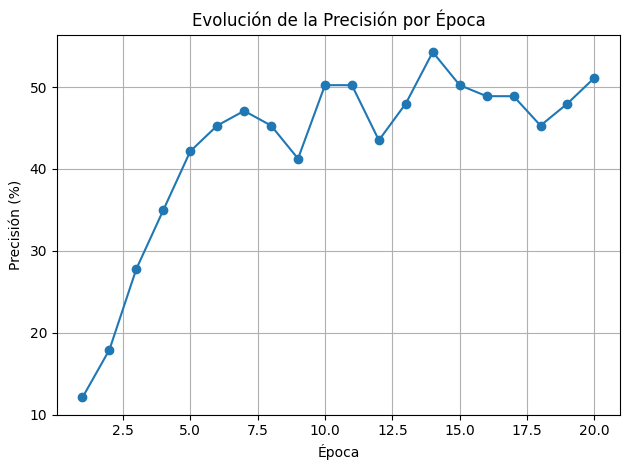

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MiCNN_definitivo_v3().to(device)

print(next(model.parameters()).device) # si está en cuda:0 está en la gráfica

criterio = nn.CrossEntropyLoss()
#criterio = nn.MultiMarginLoss()
optimizador = torch.optim.AdamW(model.parameters(), lr=0.001)
#optimizador = torch.optim.RMSprop(model.parameters(), lr=0.001)
true_labels, predicted_labels, acc = evaluate_neural_network(
    model, train_loader, val_loader,
    criteria_function=criterio,
    optimizer=optimizador,
    epochs=20,
    plot_accuracy=True
)

### Búsqueda de hiperparámetros con Optuna

A continuación se empleará Optuna, una librería para la optimización de hiperparámetros, para mejorar el rendimiento del modelo definido en el apartado anterior. Para ello pasaremos como parámetro el learning rate, el dropout rate de la capa de Dropout, y pasaremos también 2 optimizadores para afianzar las pruebas que ya hemos hecho al respecto.

In [24]:
def objective(trial):
    # Sugerencia de hiperparámetros
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7)
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "RMSprop"])
    
    # Modelo con dropout personalizado
    class CustomCNN(MiCNN_definitivo_v3):
        def __init__(self, dropout_rate):
            super().__init__()
            self.dropout = nn.Dropout(dropout_rate)
    
    model = CustomCNN(dropout_rate).to(device)
    
    # Criterio
    criterion = nn.CrossEntropyLoss()

    # Optimizador
    if optimizer_name == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    # Entrenamiento
    true_labels, predicted_labels, acc = evaluate_neural_network(
        model, train_loader, val_loader,
        criteria_function=criterion,
        optimizer=optimizer,
        epochs=10,  # para búsqueda, usa menos épocas
        plot_accuracy=False
    )

    # Calcular precisión final
    accuracy = sum(p == t for p, t in zip(predicted_labels, true_labels)) / len(true_labels)
    return accuracy

In [25]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print("Mejores hiperparámetros:", study.best_params)

[I 2025-05-25 08:54:11,739] A new study created in memory with name: no-name-1bf8ec35-8e44-4509-aa53-c90411fe91a7


Device: cuda


C:\Users\anton\AppData\Local\Temp\ipykernel_19196\3355147380.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)


Epoch 1 - Loss: 102.3080 - Accuracy: 7.62%
Epoch 2 - Loss: 82.8312 - Accuracy: 9.42%
Epoch 3 - Loss: 79.2866 - Accuracy: 12.11%
Epoch 4 - Loss: 73.7971 - Accuracy: 12.56%
Epoch 5 - Loss: 68.1568 - Accuracy: 19.28%
Epoch 6 - Loss: 65.1555 - Accuracy: 24.22%
Epoch 7 - Loss: 59.6931 - Accuracy: 21.08%
Epoch 8 - Loss: 53.1936 - Accuracy: 27.35%
Epoch 9 - Loss: 47.9050 - Accuracy: 31.84%


[I 2025-05-25 08:54:56,224] Trial 0 finished with value: 0.3183856502242152 and parameters: {'lr': 0.008664744267993275, 'dropout_rate': 0.33048510313376545, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.3183856502242152.


Epoch 10 - Loss: 40.6595 - Accuracy: 31.84%
Device: cuda
Epoch 1 - Loss: 81.1466 - Accuracy: 10.31%
Epoch 2 - Loss: 68.2473 - Accuracy: 16.14%
Epoch 3 - Loss: 59.2547 - Accuracy: 25.11%
Epoch 4 - Loss: 49.8129 - Accuracy: 30.04%
Epoch 5 - Loss: 46.0687 - Accuracy: 41.26%
Epoch 6 - Loss: 41.5403 - Accuracy: 41.26%
Epoch 7 - Loss: 36.2616 - Accuracy: 42.15%
Epoch 8 - Loss: 32.4237 - Accuracy: 41.70%
Epoch 9 - Loss: 29.4360 - Accuracy: 44.84%


[I 2025-05-25 08:55:40,529] Trial 1 finished with value: 0.47533632286995514 and parameters: {'lr': 0.001344742788979091, 'dropout_rate': 0.5288708068446646, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.47533632286995514.


Epoch 10 - Loss: 27.5245 - Accuracy: 47.53%
Device: cuda
Epoch 1 - Loss: 83.4417 - Accuracy: 10.31%
Epoch 2 - Loss: 69.0104 - Accuracy: 16.14%
Epoch 3 - Loss: 60.8803 - Accuracy: 19.73%
Epoch 4 - Loss: 53.3941 - Accuracy: 27.35%
Epoch 5 - Loss: 49.4800 - Accuracy: 35.43%
Epoch 6 - Loss: 45.2701 - Accuracy: 31.39%
Epoch 7 - Loss: 42.5295 - Accuracy: 37.67%
Epoch 8 - Loss: 38.7875 - Accuracy: 27.80%
Epoch 9 - Loss: 33.6430 - Accuracy: 36.77%


[I 2025-05-25 08:56:24,869] Trial 2 finished with value: 0.40358744394618834 and parameters: {'lr': 0.003574759220068298, 'dropout_rate': 0.39031616083500814, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.47533632286995514.


Epoch 10 - Loss: 31.4517 - Accuracy: 40.36%
Device: cuda
Epoch 1 - Loss: 82.5759 - Accuracy: 13.90%
Epoch 2 - Loss: 75.1559 - Accuracy: 14.35%
Epoch 3 - Loss: 67.1336 - Accuracy: 18.39%
Epoch 4 - Loss: 57.8369 - Accuracy: 24.66%
Epoch 5 - Loss: 51.0261 - Accuracy: 34.98%
Epoch 6 - Loss: 45.7401 - Accuracy: 30.49%
Epoch 7 - Loss: 41.6739 - Accuracy: 37.22%
Epoch 8 - Loss: 37.1799 - Accuracy: 38.12%
Epoch 9 - Loss: 34.9633 - Accuracy: 39.91%


[I 2025-05-25 08:57:09,107] Trial 3 finished with value: 0.4618834080717489 and parameters: {'lr': 0.001196930655716368, 'dropout_rate': 0.6125348741255445, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.47533632286995514.


Epoch 10 - Loss: 32.0504 - Accuracy: 46.19%
Device: cuda
Epoch 1 - Loss: 85.5186 - Accuracy: 15.25%
Epoch 2 - Loss: 69.7867 - Accuracy: 13.00%
Epoch 3 - Loss: 63.5970 - Accuracy: 17.04%
Epoch 4 - Loss: 55.5561 - Accuracy: 22.87%
Epoch 5 - Loss: 51.8975 - Accuracy: 21.97%
Epoch 6 - Loss: 47.8945 - Accuracy: 29.60%
Epoch 7 - Loss: 41.2845 - Accuracy: 37.67%
Epoch 8 - Loss: 37.3975 - Accuracy: 28.70%
Epoch 9 - Loss: 33.9569 - Accuracy: 41.26%


[I 2025-05-25 08:57:53,636] Trial 4 finished with value: 0.37668161434977576 and parameters: {'lr': 0.0037080962584954955, 'dropout_rate': 0.404332174743408, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.47533632286995514.


Epoch 10 - Loss: 31.1787 - Accuracy: 37.67%
Device: cuda
Epoch 1 - Loss: 80.2643 - Accuracy: 7.17%
Epoch 2 - Loss: 67.3091 - Accuracy: 26.01%
Epoch 3 - Loss: 57.1993 - Accuracy: 26.46%
Epoch 4 - Loss: 46.4359 - Accuracy: 28.70%
Epoch 5 - Loss: 39.1703 - Accuracy: 40.36%
Epoch 6 - Loss: 34.8163 - Accuracy: 41.70%
Epoch 7 - Loss: 30.8652 - Accuracy: 43.50%
Epoch 8 - Loss: 27.1485 - Accuracy: 40.81%
Epoch 9 - Loss: 24.2575 - Accuracy: 39.01%


[I 2025-05-25 08:58:36,982] Trial 5 finished with value: 0.5112107623318386 and parameters: {'lr': 0.0005191651807895179, 'dropout_rate': 0.5067565723493547, 'optimizer': 'AdamW'}. Best is trial 5 with value: 0.5112107623318386.


Epoch 10 - Loss: 21.6779 - Accuracy: 51.12%
Device: cuda
Epoch 1 - Loss: 81.3089 - Accuracy: 14.35%
Epoch 2 - Loss: 67.5229 - Accuracy: 14.35%
Epoch 3 - Loss: 60.9517 - Accuracy: 21.97%
Epoch 4 - Loss: 54.4102 - Accuracy: 30.49%
Epoch 5 - Loss: 50.0520 - Accuracy: 34.98%
Epoch 6 - Loss: 45.9023 - Accuracy: 38.12%
Epoch 7 - Loss: 40.4604 - Accuracy: 39.91%
Epoch 8 - Loss: 35.7227 - Accuracy: 34.53%
Epoch 9 - Loss: 32.8467 - Accuracy: 41.26%


[I 2025-05-25 08:59:20,165] Trial 6 finished with value: 0.4170403587443946 and parameters: {'lr': 0.002609015610765073, 'dropout_rate': 0.5293930770596459, 'optimizer': 'AdamW'}. Best is trial 5 with value: 0.5112107623318386.


Epoch 10 - Loss: 30.9942 - Accuracy: 41.70%
Device: cuda
Epoch 1 - Loss: 78.8142 - Accuracy: 11.66%
Epoch 2 - Loss: 64.3712 - Accuracy: 21.08%
Epoch 3 - Loss: 53.6684 - Accuracy: 26.01%
Epoch 4 - Loss: 42.5807 - Accuracy: 38.12%
Epoch 5 - Loss: 35.5680 - Accuracy: 43.05%
Epoch 6 - Loss: 30.7166 - Accuracy: 43.50%
Epoch 7 - Loss: 27.1876 - Accuracy: 49.78%
Epoch 8 - Loss: 23.5089 - Accuracy: 45.74%
Epoch 9 - Loss: 19.7444 - Accuracy: 43.50%


[I 2025-05-25 09:00:03,460] Trial 7 finished with value: 0.5067264573991032 and parameters: {'lr': 0.0005063306027479131, 'dropout_rate': 0.35844966589886756, 'optimizer': 'AdamW'}. Best is trial 5 with value: 0.5112107623318386.


Epoch 10 - Loss: 15.0836 - Accuracy: 50.67%
Device: cuda
Epoch 1 - Loss: 297.7822 - Accuracy: 11.21%
Epoch 2 - Loss: 95.0090 - Accuracy: 12.11%
Epoch 3 - Loss: 79.0104 - Accuracy: 15.70%
Epoch 4 - Loss: 75.3818 - Accuracy: 15.70%
Epoch 5 - Loss: 73.2131 - Accuracy: 15.25%
Epoch 6 - Loss: 71.0067 - Accuracy: 17.49%
Epoch 7 - Loss: 66.7269 - Accuracy: 12.11%
Epoch 8 - Loss: 64.1615 - Accuracy: 21.08%
Epoch 9 - Loss: 62.0634 - Accuracy: 19.28%


[I 2025-05-25 09:00:47,209] Trial 8 finished with value: 0.20179372197309417 and parameters: {'lr': 0.006584095997106828, 'dropout_rate': 0.6315827005030701, 'optimizer': 'RMSprop'}. Best is trial 5 with value: 0.5112107623318386.


Epoch 10 - Loss: 60.8078 - Accuracy: 20.18%
Device: cuda
Epoch 1 - Loss: 80.4350 - Accuracy: 10.76%
Epoch 2 - Loss: 68.0081 - Accuracy: 18.83%
Epoch 3 - Loss: 59.3615 - Accuracy: 17.94%
Epoch 4 - Loss: 52.2143 - Accuracy: 25.56%
Epoch 5 - Loss: 46.7689 - Accuracy: 30.94%
Epoch 6 - Loss: 43.5502 - Accuracy: 37.22%
Epoch 7 - Loss: 37.7736 - Accuracy: 33.63%
Epoch 8 - Loss: 35.8418 - Accuracy: 34.98%
Epoch 9 - Loss: 31.4409 - Accuracy: 38.57%


[I 2025-05-25 09:01:31,473] Trial 9 finished with value: 0.45739910313901344 and parameters: {'lr': 0.00048180978757604386, 'dropout_rate': 0.5505310434943982, 'optimizer': 'RMSprop'}. Best is trial 5 with value: 0.5112107623318386.


Epoch 10 - Loss: 29.5704 - Accuracy: 45.74%
Device: cuda
Epoch 1 - Loss: 82.4673 - Accuracy: 5.83%
Epoch 2 - Loss: 75.9605 - Accuracy: 22.42%
Epoch 3 - Loss: 72.1349 - Accuracy: 25.11%
Epoch 4 - Loss: 67.2863 - Accuracy: 27.35%
Epoch 5 - Loss: 64.2299 - Accuracy: 34.53%
Epoch 6 - Loss: 60.9817 - Accuracy: 35.43%
Epoch 7 - Loss: 57.1136 - Accuracy: 35.43%
Epoch 8 - Loss: 53.0685 - Accuracy: 38.57%
Epoch 9 - Loss: 50.5752 - Accuracy: 38.12%


[I 2025-05-25 09:02:15,646] Trial 10 finished with value: 0.4260089686098655 and parameters: {'lr': 4.1768767013171364e-05, 'dropout_rate': 0.6983718688085394, 'optimizer': 'RMSprop'}. Best is trial 5 with value: 0.5112107623318386.


Epoch 10 - Loss: 48.5830 - Accuracy: 42.60%
Device: cuda
Epoch 1 - Loss: 81.0809 - Accuracy: 6.73%
Epoch 2 - Loss: 69.8563 - Accuracy: 26.01%
Epoch 3 - Loss: 60.6749 - Accuracy: 28.25%
Epoch 4 - Loss: 51.1124 - Accuracy: 38.57%
Epoch 5 - Loss: 42.9747 - Accuracy: 41.70%
Epoch 6 - Loss: 36.0272 - Accuracy: 41.70%
Epoch 7 - Loss: 30.1385 - Accuracy: 42.15%
Epoch 8 - Loss: 24.6939 - Accuracy: 46.64%
Epoch 9 - Loss: 20.3662 - Accuracy: 43.95%


[I 2025-05-25 09:02:59,949] Trial 11 finished with value: 0.5201793721973094 and parameters: {'lr': 0.00014071053709344326, 'dropout_rate': 0.4466525137177335, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.5201793721973094.


Epoch 10 - Loss: 15.4499 - Accuracy: 52.02%
Device: cuda
Epoch 1 - Loss: 81.7118 - Accuracy: 8.07%
Epoch 2 - Loss: 72.3497 - Accuracy: 25.56%
Epoch 3 - Loss: 63.9339 - Accuracy: 30.49%
Epoch 4 - Loss: 55.9240 - Accuracy: 40.81%
Epoch 5 - Loss: 48.3835 - Accuracy: 37.22%
Epoch 6 - Loss: 40.8991 - Accuracy: 41.26%
Epoch 7 - Loss: 34.6529 - Accuracy: 43.50%
Epoch 8 - Loss: 28.5492 - Accuracy: 47.53%
Epoch 9 - Loss: 24.0640 - Accuracy: 48.43%


[I 2025-05-25 09:03:44,337] Trial 12 finished with value: 0.45739910313901344 and parameters: {'lr': 8.890070273100173e-05, 'dropout_rate': 0.4427774910767615, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.5201793721973094.


Epoch 10 - Loss: 18.8005 - Accuracy: 45.74%
Device: cuda
Epoch 1 - Loss: 81.4004 - Accuracy: 7.17%
Epoch 2 - Loss: 70.6126 - Accuracy: 25.56%
Epoch 3 - Loss: 61.1200 - Accuracy: 30.94%
Epoch 4 - Loss: 52.0867 - Accuracy: 43.05%
Epoch 5 - Loss: 43.7567 - Accuracy: 42.60%
Epoch 6 - Loss: 36.9357 - Accuracy: 45.29%
Epoch 7 - Loss: 31.1637 - Accuracy: 49.33%
Epoch 8 - Loss: 25.1370 - Accuracy: 44.39%
Epoch 9 - Loss: 21.0244 - Accuracy: 49.78%


[I 2025-05-25 09:04:27,495] Trial 13 finished with value: 0.5067264573991032 and parameters: {'lr': 0.00014314557041357197, 'dropout_rate': 0.463158259704432, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.5201793721973094.


Epoch 10 - Loss: 15.9324 - Accuracy: 50.67%
Device: cuda
Epoch 1 - Loss: 81.9973 - Accuracy: 8.07%
Epoch 2 - Loss: 74.2134 - Accuracy: 22.42%
Epoch 3 - Loss: 69.6560 - Accuracy: 26.01%
Epoch 4 - Loss: 65.7638 - Accuracy: 29.15%
Epoch 5 - Loss: 62.0012 - Accuracy: 31.39%
Epoch 6 - Loss: 58.9189 - Accuracy: 31.84%
Epoch 7 - Loss: 55.8994 - Accuracy: 33.63%
Epoch 8 - Loss: 52.1659 - Accuracy: 38.57%
Epoch 9 - Loss: 49.3439 - Accuracy: 36.77%


[I 2025-05-25 09:05:12,252] Trial 14 finished with value: 0.3721973094170404 and parameters: {'lr': 1.9512842850873563e-05, 'dropout_rate': 0.4681586174041136, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.5201793721973094.


Epoch 10 - Loss: 46.6634 - Accuracy: 37.22%
Device: cuda
Epoch 1 - Loss: 82.3075 - Accuracy: 7.17%
Epoch 2 - Loss: 73.0658 - Accuracy: 25.11%
Epoch 3 - Loss: 65.3188 - Accuracy: 28.70%
Epoch 4 - Loss: 57.1167 - Accuracy: 37.22%
Epoch 5 - Loss: 49.6650 - Accuracy: 39.46%
Epoch 6 - Loss: 43.0857 - Accuracy: 43.05%
Epoch 7 - Loss: 37.6576 - Accuracy: 42.60%
Epoch 8 - Loss: 32.4727 - Accuracy: 45.74%
Epoch 9 - Loss: 28.2205 - Accuracy: 45.74%


[I 2025-05-25 09:05:56,271] Trial 15 finished with value: 0.5112107623318386 and parameters: {'lr': 0.00016304190059471865, 'dropout_rate': 0.5910329599028253, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.5201793721973094.


Epoch 10 - Loss: 24.5112 - Accuracy: 51.12%
Device: cuda
Epoch 1 - Loss: 85.2596 - Accuracy: 4.48%
Epoch 2 - Loss: 81.8403 - Accuracy: 8.07%
Epoch 3 - Loss: 79.5003 - Accuracy: 12.11%
Epoch 4 - Loss: 77.8216 - Accuracy: 15.70%
Epoch 5 - Loss: 75.9627 - Accuracy: 17.94%
Epoch 6 - Loss: 74.6429 - Accuracy: 18.83%
Epoch 7 - Loss: 72.9625 - Accuracy: 20.63%
Epoch 8 - Loss: 70.9273 - Accuracy: 25.11%
Epoch 9 - Loss: 69.3578 - Accuracy: 23.77%


[I 2025-05-25 09:06:40,272] Trial 16 finished with value: 0.24663677130044842 and parameters: {'lr': 1.02356705696715e-05, 'dropout_rate': 0.4955640554076166, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.5201793721973094.


Epoch 10 - Loss: 67.4917 - Accuracy: 24.66%
Device: cuda
Epoch 1 - Loss: 78.5809 - Accuracy: 10.31%
Epoch 2 - Loss: 64.4462 - Accuracy: 24.22%
Epoch 3 - Loss: 52.4568 - Accuracy: 29.15%
Epoch 4 - Loss: 41.7384 - Accuracy: 35.43%
Epoch 5 - Loss: 33.9366 - Accuracy: 45.74%
Epoch 6 - Loss: 27.1691 - Accuracy: 42.15%
Epoch 7 - Loss: 23.7958 - Accuracy: 50.22%
Epoch 8 - Loss: 17.6925 - Accuracy: 49.33%
Epoch 9 - Loss: 15.4086 - Accuracy: 42.15%


[I 2025-05-25 09:07:24,378] Trial 17 finished with value: 0.5650224215246636 and parameters: {'lr': 0.00032630902197839333, 'dropout_rate': 0.3032930169666084, 'optimizer': 'AdamW'}. Best is trial 17 with value: 0.5650224215246636.


Epoch 10 - Loss: 11.4267 - Accuracy: 56.50%
Device: cuda
Epoch 1 - Loss: 77.1591 - Accuracy: 9.87%
Epoch 2 - Loss: 63.2384 - Accuracy: 31.39%
Epoch 3 - Loss: 52.8884 - Accuracy: 35.43%
Epoch 4 - Loss: 44.5343 - Accuracy: 38.57%
Epoch 5 - Loss: 37.7806 - Accuracy: 39.46%
Epoch 6 - Loss: 31.8497 - Accuracy: 45.29%
Epoch 7 - Loss: 26.9102 - Accuracy: 48.43%
Epoch 8 - Loss: 22.0760 - Accuracy: 47.98%
Epoch 9 - Loss: 18.5018 - Accuracy: 52.02%


[I 2025-05-25 09:08:08,277] Trial 18 finished with value: 0.5291479820627802 and parameters: {'lr': 7.243063893112273e-05, 'dropout_rate': 0.3144246630706564, 'optimizer': 'RMSprop'}. Best is trial 17 with value: 0.5650224215246636.


Epoch 10 - Loss: 15.1975 - Accuracy: 52.91%
Device: cuda
Epoch 1 - Loss: 77.1511 - Accuracy: 7.62%
Epoch 2 - Loss: 64.4030 - Accuracy: 33.63%
Epoch 3 - Loss: 54.6975 - Accuracy: 38.12%
Epoch 4 - Loss: 46.7012 - Accuracy: 36.32%
Epoch 5 - Loss: 40.3278 - Accuracy: 43.05%
Epoch 6 - Loss: 34.4210 - Accuracy: 43.50%
Epoch 7 - Loss: 29.7180 - Accuracy: 46.19%
Epoch 8 - Loss: 24.8449 - Accuracy: 47.98%
Epoch 9 - Loss: 21.1785 - Accuracy: 51.57%


[I 2025-05-25 09:08:51,260] Trial 19 finished with value: 0.4977578475336323 and parameters: {'lr': 5.493370125307493e-05, 'dropout_rate': 0.3118548938062765, 'optimizer': 'RMSprop'}. Best is trial 17 with value: 0.5650224215246636.


Epoch 10 - Loss: 17.7141 - Accuracy: 49.78%
Mejores hiperparámetros: {'lr': 0.00032630902197839333, 'dropout_rate': 0.3032930169666084, 'optimizer': 'AdamW'}


Como resultado tenemos que los mejores hiperparámetros son:
* Learning rate: 0.00032630902197839333
* Dropout rate: 0.3032930169666084
* Optimizer: AdamW

Como podemos comprobar, el mejor optimizador sigue siendo AdamW. A continuación ejecutamos un experimento con estos nuevos hiperparámetros. En 100 épocas obtenemos un accuracy del 61.43%.

cuda:0
Device: cuda
Epoch 1 - Loss: 79.4851 - Accuracy: 7.62%
Epoch 2 - Loss: 66.3495 - Accuracy: 28.25%
Epoch 3 - Loss: 54.6081 - Accuracy: 35.43%
Epoch 4 - Loss: 43.6593 - Accuracy: 38.57%
Epoch 5 - Loss: 35.6007 - Accuracy: 43.50%
Epoch 6 - Loss: 28.5083 - Accuracy: 45.74%
Epoch 7 - Loss: 23.8148 - Accuracy: 52.47%
Epoch 8 - Loss: 17.5346 - Accuracy: 48.88%
Epoch 9 - Loss: 13.5522 - Accuracy: 49.78%
Epoch 10 - Loss: 9.3275 - Accuracy: 58.30%
Epoch 11 - Loss: 6.5153 - Accuracy: 55.16%
Epoch 12 - Loss: 5.0176 - Accuracy: 52.47%
Epoch 13 - Loss: 3.8341 - Accuracy: 54.71%
Epoch 14 - Loss: 2.3132 - Accuracy: 56.50%
Epoch 15 - Loss: 1.7746 - Accuracy: 58.30%
Epoch 16 - Loss: 1.1650 - Accuracy: 56.50%
Epoch 17 - Loss: 0.8274 - Accuracy: 59.64%
Epoch 18 - Loss: 0.6779 - Accuracy: 60.09%
Epoch 19 - Loss: 0.5108 - Accuracy: 58.30%
Epoch 20 - Loss: 0.3844 - Accuracy: 58.74%
Epoch 21 - Loss: 0.3582 - Accuracy: 60.09%
Epoch 22 - Loss: 0.3414 - Accuracy: 60.99%
Epoch 23 - Loss: 0.2620 - Accuracy:

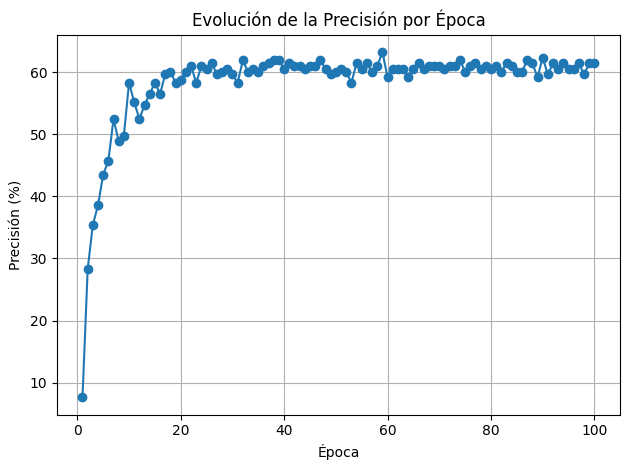

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MiCNN_definitivo_v3().to(device)

print(next(model.parameters()).device) # si está en cuda:0 está en la gráfica

criterio = nn.CrossEntropyLoss()
#criterio = nn.MultiMarginLoss()
optimizador = torch.optim.AdamW(model.parameters(), lr=0.0001950711576250917)
#optimizador = torch.optim.RMSprop(model.parameters(), lr=0.001)
y_true5, y_pred5, acc5 = evaluate_neural_network(
    model, train_loader, val_loader,
    criteria_function=criterio,
    optimizer=optimizador,
    epochs=100,
    plot_accuracy=True
)

### Aplicación de pesos a función de pérdida

La implementación de AdamW de pytorch soporta un parámetro `weight` al que se le puede pasar un array de pesos o sesgos para la capa de salida. Esto es especialmente interesante ya que podemos calcular la representación de cada clase en el conjunto de entrenamiento e indicarle un peso para cada una, para que las clases menos representadas sean más relevantes a la hora de entrenar.

cuda:0
Device: cuda
Epoch 1 - Loss: 80.3086 - Accuracy: 9.42%
Epoch 2 - Loss: 68.0956 - Accuracy: 28.25%
Epoch 3 - Loss: 56.2028 - Accuracy: 29.60%
Epoch 4 - Loss: 44.0474 - Accuracy: 42.60%
Epoch 5 - Loss: 37.0640 - Accuracy: 41.70%
Epoch 6 - Loss: 29.8340 - Accuracy: 44.39%
Epoch 7 - Loss: 23.3195 - Accuracy: 47.09%
Epoch 8 - Loss: 19.5367 - Accuracy: 48.43%
Epoch 9 - Loss: 13.5008 - Accuracy: 48.88%
Epoch 10 - Loss: 9.2959 - Accuracy: 55.16%
Epoch 11 - Loss: 6.3885 - Accuracy: 56.05%
Epoch 12 - Loss: 4.6631 - Accuracy: 55.16%
Epoch 13 - Loss: 3.4813 - Accuracy: 50.67%
Epoch 14 - Loss: 2.3393 - Accuracy: 53.36%
Epoch 15 - Loss: 1.5953 - Accuracy: 55.61%
Epoch 16 - Loss: 1.1584 - Accuracy: 56.50%
Epoch 17 - Loss: 0.7441 - Accuracy: 59.19%
Epoch 18 - Loss: 0.5341 - Accuracy: 56.95%
Epoch 19 - Loss: 0.4623 - Accuracy: 57.85%
Epoch 20 - Loss: 0.3493 - Accuracy: 59.19%
Epoch 21 - Loss: 0.2990 - Accuracy: 56.95%
Epoch 22 - Loss: 0.2611 - Accuracy: 57.85%
Epoch 23 - Loss: 0.2391 - Accuracy:

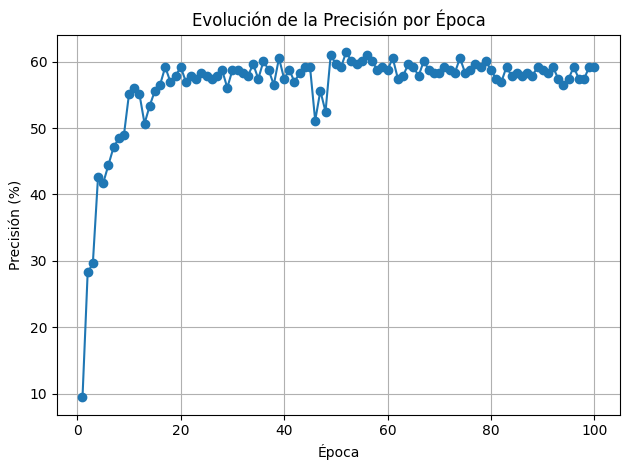

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MiCNN_definitivo_v3().to(device)

print(next(model.parameters()).device)

# Obtener etiquetas de todo el dataset de entrenamiento
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.cpu().numpy())
    
# Calcular la frecuencia de cada clase
label_counts = Counter(all_labels)
num_classes = len(label_counts)
counts = torch.tensor([label_counts[i] for i in range(num_classes)], dtype=torch.float)

# Calcular pesos inversos para las clases
class_weights = 1. / counts
class_weights = class_weights.to(device)

criterio = nn.CrossEntropyLoss(weight=class_weights)

optimizador = torch.optim.AdamW(model.parameters(), lr=0.0001950711576250917)

true_labels, predicted_labels, acc = evaluate_neural_network(
    model, train_loader, val_loader,
    criteria_function=criterio,
    optimizer=optimizador,
    epochs=100,
    plot_accuracy=True
)

Obtenemos unos resultados ligeramente peores con 100 épocas, y con un pico no demasiado relevante sobre las épocas 50, por lo que este cambio no afecta significativamente al modelo.

### Data Augmentation

Procedemos a aplicar la técnica Data Augmentation para aplicar recortes, volteos, rotaciones y filtros de color a las imágenes del conjunto de entrenamiento. Esto se hace con la intención de mejorar la genralización del modelo.

In [28]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dataset_augmented = ImageFolder(root=ruta_imagenes_x20, transform=train_transform)
test_dataset_augmented = ImageFolder(root=ruta_imagenes_x20, transform=test_transform)

train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)
test_loader_augmented = DataLoader(test_dataset_augmented, batch_size=32, shuffle=False)

cuda:0
Device: cuda
Epoch 1 - Loss: 101.9568 - Accuracy: 20.27%
Epoch 2 - Loss: 92.2502 - Accuracy: 32.38%
Epoch 3 - Loss: 86.8178 - Accuracy: 40.54%
Epoch 4 - Loss: 82.1387 - Accuracy: 43.50%
Epoch 5 - Loss: 79.9204 - Accuracy: 41.88%
Epoch 6 - Loss: 74.8439 - Accuracy: 48.79%
Epoch 7 - Loss: 70.9279 - Accuracy: 51.30%
Epoch 8 - Loss: 71.5118 - Accuracy: 50.40%
Epoch 9 - Loss: 69.8086 - Accuracy: 58.74%
Epoch 10 - Loss: 66.0288 - Accuracy: 56.95%
Epoch 11 - Loss: 66.2724 - Accuracy: 60.90%
Epoch 12 - Loss: 65.4449 - Accuracy: 58.74%
Epoch 13 - Loss: 61.4538 - Accuracy: 59.37%
Epoch 14 - Loss: 63.6544 - Accuracy: 60.99%
Epoch 15 - Loss: 60.7254 - Accuracy: 65.29%
Epoch 16 - Loss: 58.9336 - Accuracy: 68.70%
Epoch 17 - Loss: 58.6839 - Accuracy: 66.82%
Epoch 18 - Loss: 56.3679 - Accuracy: 69.24%
Epoch 19 - Loss: 56.3071 - Accuracy: 66.91%
Epoch 20 - Loss: 57.4554 - Accuracy: 70.31%
Epoch 21 - Loss: 53.6809 - Accuracy: 68.16%
Epoch 22 - Loss: 53.6948 - Accuracy: 70.40%
Epoch 23 - Loss: 52.

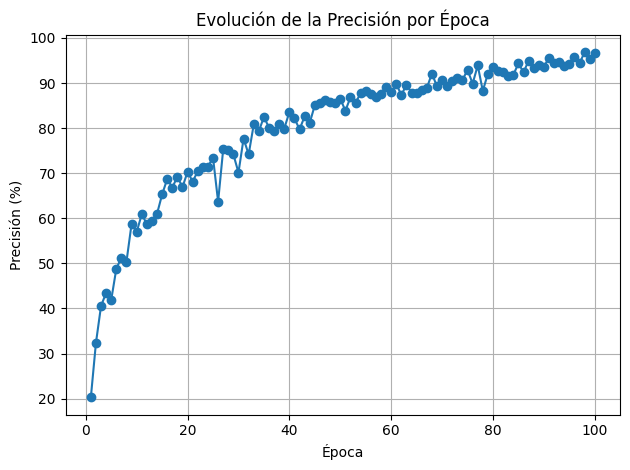

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MiCNN_definitivo_v3().to(device)

print(next(model.parameters()).device) # si está en cuda:0 está en la gráfica

criterio = nn.CrossEntropyLoss()
optimizador = torch.optim.AdamW(model.parameters(), lr=0.0001950711576250917)
y_true0, y_pred0, acc0 = evaluate_neural_network(
    model, train_loader_augmented , test_loader_augmented ,
    criteria_function=criterio,
    optimizer=optimizador,
    epochs=100,
    plot_accuracy=True
)

Observamos un aumento muy significativo en los resultados, en los que se llega a un 96.86% de precisión en test. En la gráfica podemos observar que la tendencia es creciente cuanta más épocas se entrenen, por lo que podemos suponer que el modelo no presenta overfitting y se mejorarían más los resultados de entrenarlo durante más época, cosa que no se hará por el tiempo de cómputo.

## Modelo Resnet50 con fine-tuning

Ahora procederemos a hacer fine tuning a un modelo pre entrenado. Para ello hemos elegido Resnet50 entre otras (EfficientNet, MobileNetV3) ya que suele ser un modelo robusto y funciona bien para un número no elevado de clases. Realizaremos 2 experimentos: feature extraction, consistente en ajustar únicamente la capa de salida a los datos congelando el resto, y fine tuning completo, donde se ajustan todas las capas. Se probará también a aplicar data augmentation para ver si mejoran los resultados, ya que dieron muy buenas cifras con el modelo propio.

### Feature extraction

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50(weights="IMAGENET1K_V1")

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 20)

for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

y_true1, y_pred1, acc1 = evaluate_neural_network(model, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, epochs=20)

Device: cuda
Epoch 1 - Loss: 82.4342 - Accuracy: 14.80%
Epoch 2 - Loss: 75.4528 - Accuracy: 40.36%
Epoch 3 - Loss: 69.8341 - Accuracy: 51.57%
Epoch 4 - Loss: 64.0930 - Accuracy: 60.54%
Epoch 5 - Loss: 59.2752 - Accuracy: 64.13%
Epoch 6 - Loss: 55.1197 - Accuracy: 71.75%
Epoch 7 - Loss: 51.2820 - Accuracy: 73.54%
Epoch 8 - Loss: 47.6429 - Accuracy: 75.78%
Epoch 9 - Loss: 44.5475 - Accuracy: 74.89%
Epoch 10 - Loss: 41.5294 - Accuracy: 76.68%
Epoch 11 - Loss: 38.9809 - Accuracy: 77.13%
Epoch 12 - Loss: 36.6431 - Accuracy: 78.03%
Epoch 13 - Loss: 34.2300 - Accuracy: 77.58%
Epoch 14 - Loss: 33.2738 - Accuracy: 77.58%
Epoch 15 - Loss: 31.0241 - Accuracy: 78.48%
Epoch 16 - Loss: 29.5044 - Accuracy: 79.37%
Epoch 17 - Loss: 27.9607 - Accuracy: 78.48%
Epoch 18 - Loss: 26.6213 - Accuracy: 79.37%
Epoch 19 - Loss: 25.7836 - Accuracy: 79.82%
Epoch 20 - Loss: 24.2223 - Accuracy: 80.27%


### Feature extraction utilizando datos aumentados

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50(weights="IMAGENET1K_V1")

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 20)

for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

y_true2, y_pred2, acc2 = evaluate_neural_network(model, train_loader_augmented, test_loader_augmented, nn.CrossEntropyLoss(), optimizer, epochs=20)

Device: cuda
Epoch 1 - Loss: 102.8313 - Accuracy: 24.04%
Epoch 2 - Loss: 96.2879 - Accuracy: 43.05%
Epoch 3 - Loss: 89.8643 - Accuracy: 57.94%
Epoch 4 - Loss: 84.8114 - Accuracy: 67.17%
Epoch 5 - Loss: 80.5552 - Accuracy: 69.69%
Epoch 6 - Loss: 75.9379 - Accuracy: 76.95%
Epoch 7 - Loss: 71.9371 - Accuracy: 79.64%
Epoch 8 - Loss: 68.3824 - Accuracy: 80.27%
Epoch 9 - Loss: 65.6128 - Accuracy: 84.04%
Epoch 10 - Loss: 63.0095 - Accuracy: 83.77%
Epoch 11 - Loss: 59.9416 - Accuracy: 84.39%
Epoch 12 - Loss: 57.7215 - Accuracy: 86.19%
Epoch 13 - Loss: 54.6131 - Accuracy: 86.37%
Epoch 14 - Loss: 53.9740 - Accuracy: 86.64%
Epoch 15 - Loss: 51.1602 - Accuracy: 87.09%
Epoch 16 - Loss: 49.6913 - Accuracy: 87.35%
Epoch 17 - Loss: 48.3026 - Accuracy: 87.89%
Epoch 18 - Loss: 46.5814 - Accuracy: 88.16%
Epoch 19 - Loss: 45.7355 - Accuracy: 88.52%
Epoch 20 - Loss: 44.7575 - Accuracy: 89.06%


### Fine tuning completo

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50(weights="IMAGENET1K_V1")

model.fc = nn.Linear(model.fc.in_features, 20)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

y_true3, y_pred3, acc3 = evaluate_neural_network(model, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, epochs=20)

Device: cuda
Epoch 1 - Loss: 56.8811 - Accuracy: 78.48%
Epoch 2 - Loss: 13.1858 - Accuracy: 88.34%
Epoch 3 - Loss: 3.4057 - Accuracy: 90.13%
Epoch 4 - Loss: 1.1098 - Accuracy: 86.55%
Epoch 5 - Loss: 0.7029 - Accuracy: 87.44%
Epoch 6 - Loss: 0.4769 - Accuracy: 88.34%
Epoch 7 - Loss: 0.3549 - Accuracy: 87.89%
Epoch 8 - Loss: 0.4733 - Accuracy: 88.34%
Epoch 9 - Loss: 0.6971 - Accuracy: 86.10%
Epoch 10 - Loss: 0.3147 - Accuracy: 87.89%
Epoch 11 - Loss: 0.2053 - Accuracy: 88.79%
Epoch 12 - Loss: 0.1753 - Accuracy: 84.75%
Epoch 13 - Loss: 1.0575 - Accuracy: 84.30%
Epoch 14 - Loss: 1.5664 - Accuracy: 83.41%
Epoch 15 - Loss: 1.5779 - Accuracy: 79.37%
Epoch 16 - Loss: 2.1584 - Accuracy: 80.72%
Epoch 17 - Loss: 3.9501 - Accuracy: 79.82%
Epoch 18 - Loss: 1.9977 - Accuracy: 82.06%
Epoch 19 - Loss: 1.3788 - Accuracy: 85.20%
Epoch 20 - Loss: 0.7417 - Accuracy: 82.51%


### Fine tuning con datos aumentados

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50(weights="IMAGENET1K_V1")

model.fc = nn.Linear(model.fc.in_features, 20)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

y_true4, y_pred4, acc4 = evaluate_neural_network(model, train_loader_augmented, test_loader_augmented, nn.CrossEntropyLoss(), optimizer, epochs=20)

Device: cuda
Epoch 1 - Loss: 73.2476 - Accuracy: 84.04%
Epoch 2 - Loss: 30.1744 - Accuracy: 93.72%
Epoch 3 - Loss: 20.9107 - Accuracy: 96.86%
Epoch 4 - Loss: 18.4534 - Accuracy: 96.50%
Epoch 5 - Loss: 16.2210 - Accuracy: 97.49%
Epoch 6 - Loss: 14.7157 - Accuracy: 97.94%
Epoch 7 - Loss: 13.7859 - Accuracy: 98.83%
Epoch 8 - Loss: 12.6782 - Accuracy: 99.46%
Epoch 9 - Loss: 14.6957 - Accuracy: 99.19%
Epoch 10 - Loss: 12.6512 - Accuracy: 99.64%
Epoch 11 - Loss: 12.3259 - Accuracy: 99.55%
Epoch 12 - Loss: 12.4863 - Accuracy: 100.00%
Epoch 13 - Loss: 10.6505 - Accuracy: 99.46%
Epoch 14 - Loss: 11.4353 - Accuracy: 99.55%
Epoch 15 - Loss: 10.6107 - Accuracy: 99.46%
Epoch 16 - Loss: 10.3785 - Accuracy: 99.73%
Epoch 17 - Loss: 11.4790 - Accuracy: 99.55%
Epoch 18 - Loss: 7.9542 - Accuracy: 99.64%
Epoch 19 - Loss: 9.4060 - Accuracy: 99.73%
Epoch 20 - Loss: 10.9532 - Accuracy: 99.82%


### Comparacion de resultados

Podemos observar que Resnet obtiene unos resultados excelentes con muy pocas épocas, especialmente el fine-tuning completo aplicando data augmentation. Comparado con el modelo propio, escalan la accuracy en test en menos épocas y por tanto los tiempos de entrenamientos son menores, además de que se llegan a resultados mucho mejores de casi el 100% de acierto.

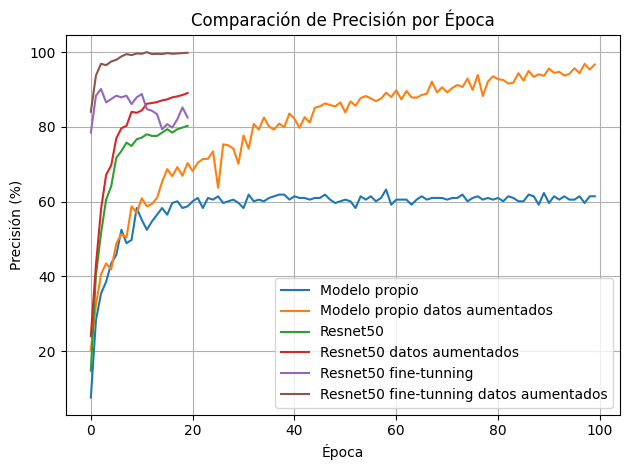

In [34]:
plt.plot(acc5, label="Modelo propio")
plt.plot(acc0, label="Modelo propio datos aumentados")
plt.plot(acc1, label="Resnet50")
plt.plot(acc2, label="Resnet50 datos aumentados")
plt.plot(acc3, label="Resnet50 fine-tunning")
plt.plot(acc4, label="Resnet50 fine-tunning datos aumentados")
plt.xlabel("Época")
plt.ylabel("Precisión (%)")
plt.title("Comparación de Precisión por Época")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Ampliación a 200 clases

A continuación ampliaremos nuestra solución para 200 clases, tanto el modelo propio como el mejor caso de Resnet50.

In [35]:
ruta_imagenes_x200 = 'archivos/data x200'

# Transformaciones necesarias (hay que convertir las imágenes a tensores)
transformaciones = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Dataset con transformaciones
dataset = datasets.ImageFolder(root=ruta_imagenes_x200, transform=transformaciones)

# Agrupamos en lotes de 20 imágenes para el entrenamiento, mezclándolas.
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Verificar
images, labels = next(iter(dataloader))
print(f"Forma del lote: {images.shape}")
print(f"Clases (primer lote): {labels}")

# Selección de las primeras 200 clases (etiquetas 0 a 199)
indices_filtrados = [i for i, (_, label) in enumerate(dataset) if label < 200]
dataset_200_clases = Subset(dataset, indices_filtrados)

# División en entrenamiento y validación
tam_total = len(dataset_200_clases)
tam_train = int(0.8 * tam_total)
tam_val = tam_total - tam_train

generator = torch.Generator().manual_seed(42)  # semilla para reproducibilidad
dataset_train, dataset_val = random_split(dataset_200_clases, [tam_train, tam_val], generator=generator)

# DataLoaders
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32)

# Obtener el primer batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

#Data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dataset_augmented = ImageFolder(root=ruta_imagenes_x200, transform=train_transform)
test_dataset_augmented = ImageFolder(root=ruta_imagenes_x200, transform=test_transform)

train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)
test_loader_augmented = DataLoader(test_dataset_augmented, batch_size=32, shuffle=False)

Forma del lote: torch.Size([32, 3, 224, 224])
Clases (primer lote): tensor([126, 103,   2,  22, 156, 149,  54, 144, 172,  13,  84,  95,  86, 116,
        152, 138,  77,  94,  44, 123, 152, 130, 121,  27, 156, 139, 190, 197,
        177,  11,   7,  63])


Ajustamos la capa de salida del modelo propio para darle mayor capacidad neuronal.

In [36]:
class MiCNN_definitivo_v3_200(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 320, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(320)

        self.conv5 = nn.Conv2d(320, 500, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(500)

        self.conv6 = nn.Conv2d(500, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.33955714678659366)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(256 * 3 * 3, 256)
        self.output = nn.Linear(256, 200)  # 200 clases

    def forward(self, x):
        x = self.pooling(self.relu(self.bn1(self.conv1(x))))
        x = self.pooling(self.relu(self.bn2(self.conv2(x))))
        x = self.pooling(self.relu(self.bn3(self.conv3(x))))
        x = self.pooling(self.relu(self.bn4(self.conv4(x))))
        x = self.pooling(self.relu(self.bn5(self.conv5(x))))
        x = self.pooling(self.relu(self.bn6(self.conv6(x))))

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.linear(x))
        x = self.output(x)
        return x

cuda:0
Device: cuda
Epoch 1 - Loss: 1889.7234 - Accuracy: 3.32%
Epoch 2 - Loss: 1755.7368 - Accuracy: 6.65%
Epoch 3 - Loss: 1661.6569 - Accuracy: 10.56%
Epoch 4 - Loss: 1595.2821 - Accuracy: 14.84%
Epoch 5 - Loss: 1522.6490 - Accuracy: 20.18%
Epoch 6 - Loss: 1468.0223 - Accuracy: 22.74%
Epoch 7 - Loss: 1416.2761 - Accuracy: 23.53%
Epoch 8 - Loss: 1373.1360 - Accuracy: 30.54%
Epoch 9 - Loss: 1325.8052 - Accuracy: 33.42%
Epoch 10 - Loss: 1295.7357 - Accuracy: 33.88%
Epoch 11 - Loss: 1259.2174 - Accuracy: 36.81%
Epoch 12 - Loss: 1228.9517 - Accuracy: 40.88%
Epoch 13 - Loss: 1196.9816 - Accuracy: 43.46%
Epoch 14 - Loss: 1165.7419 - Accuracy: 44.28%
Epoch 15 - Loss: 1129.8922 - Accuracy: 44.10%
Epoch 16 - Loss: 1118.2118 - Accuracy: 46.77%
Epoch 17 - Loss: 1091.3172 - Accuracy: 49.24%
Epoch 18 - Loss: 1060.8868 - Accuracy: 51.43%
Epoch 19 - Loss: 1056.7141 - Accuracy: 51.52%
Epoch 20 - Loss: 1026.1497 - Accuracy: 53.91%


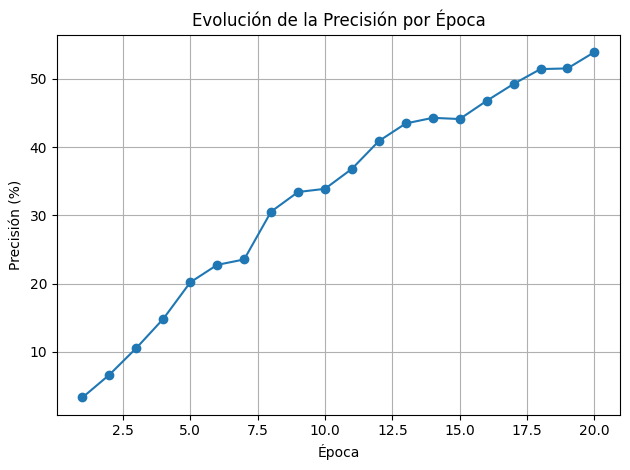

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MiCNN_definitivo_v3_200().to(device)

print(next(model.parameters()).device) # si está en cuda:0 está en la gráfica

criterio = nn.CrossEntropyLoss()
optimizador = torch.optim.AdamW(model.parameters(), lr=0.0001950711576250917)
y_true1, y_pred1, acc1  = evaluate_neural_network(
    model, train_loader_augmented , test_loader_augmented ,
    criteria_function=criterio,
    optimizer=optimizador,
    #epochs=100,
    epochs=20,
    plot_accuracy=True
)

### Resnet50

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50(weights="IMAGENET1K_V1")

model.fc = nn.Linear(model.fc.in_features, 200)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

y_true2, y_pred2, acc2 = evaluate_neural_network(model, train_loader_augmented, test_loader_augmented, nn.CrossEntropyLoss(), optimizer, epochs=20)

Device: cuda
Epoch 1 - Loss: 1348.5112 - Accuracy: 57.55%
Epoch 2 - Loss: 781.0512 - Accuracy: 72.67%
Epoch 3 - Loss: 609.5294 - Accuracy: 79.30%
Epoch 4 - Loss: 530.1804 - Accuracy: 82.60%
Epoch 5 - Loss: 476.4803 - Accuracy: 85.19%
Epoch 6 - Loss: 440.4283 - Accuracy: 86.31%
Epoch 7 - Loss: 412.0291 - Accuracy: 88.00%
Epoch 8 - Loss: 394.5175 - Accuracy: 91.26%
Epoch 9 - Loss: 379.0204 - Accuracy: 89.79%
Epoch 10 - Loss: 371.6358 - Accuracy: 90.07%
Epoch 11 - Loss: 348.3853 - Accuracy: 92.16%
Epoch 12 - Loss: 340.8822 - Accuracy: 92.64%
Epoch 13 - Loss: 325.0897 - Accuracy: 93.88%
Epoch 14 - Loss: 316.2105 - Accuracy: 94.90%
Epoch 15 - Loss: 307.9844 - Accuracy: 93.72%
Epoch 16 - Loss: 288.1620 - Accuracy: 95.37%
Epoch 17 - Loss: 291.9715 - Accuracy: 94.95%
Epoch 18 - Loss: 282.4800 - Accuracy: 95.59%
Epoch 19 - Loss: 292.2181 - Accuracy: 96.54%
Epoch 20 - Loss: 273.2104 - Accuracy: 95.95%


En este caso Resnet50 obtiene de nuevo mejores resultados que el modelo propio. La gran ventaja del primero son los menores tiempos de entrenamiento. Aunque el modelo propio presenta aquí también una tendencia creciente, lo que nos sugiere que de entrenarlo durante más época mejoraría la precisión, es computacionalmente poco asumible.

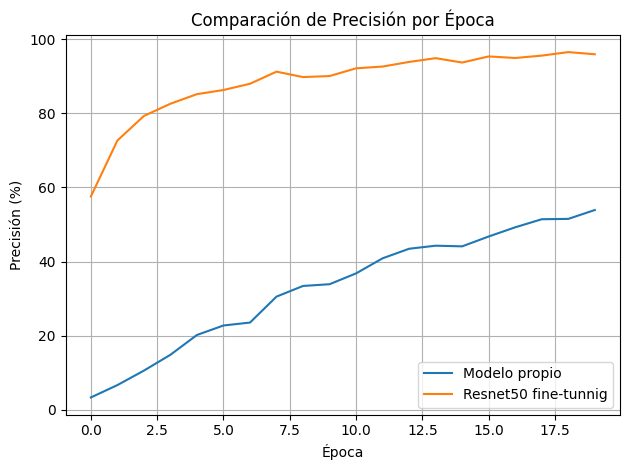

In [39]:
plt.plot(acc1, label="Modelo propio")
plt.plot(acc2, label="Resnet50 fine-tunnig")
plt.xlabel("Época")
plt.ylabel("Precisión (%)")
plt.title("Comparación de Precisión por Época")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()